## REINFORCE Algorithm

- Type of <font color='#00ba47'>policy gradient based method</font> (ie directly computes the policy without calculating the value function)
- It learns a <font color='#00ba47'>stochastic policy</font> and our neural network’s output is an action vector that represents a probability distribution (rather than returning a single deterministic action).
- Therefore REINFORCE selects an action from this probability distribution, ie if our Agent ends up in the same state twice, we may not end up taking the same action every time
- In this method, we’re trying to increase the probability of actions that have given us good total reward and decrease the probability of actions with bad final outcomes as shown in the below equation:

Expected Return:
$$U(\theta) = \sum_{\tau} P(\tau; \theta)R(\tau)$$ 
which on simplifying yeilds:
$$\nabla_{\theta}U(\theta) = \sum_{t=0}^{H}\nabla_{\theta} \log \pi_{\theta}(a_t | s_t) G_{t}$$ 
$$\theta = \theta + \alpha \nabla_{\theta}U(\theta)$$

Here, $\pi$ is the function approximator, NN in our case and $\theta$ is the parameter that updates it, ie NN parameters (weights) in our case

In [1]:
ENV = "CartPole-v0"
REWARD_MAX = 195

In [2]:
import gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import torch
torch.manual_seed(0) # set random seed
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

In [3]:
import gym
env = gym.make(ENV)
device = torch.device("mps" if torch.has_mps else "cpu")

/opt/homebrew/Caskroom/miniforge/base/envs/pytorch/lib/python3.9/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(


In [4]:
obs_size = env.observation_space.shape[0] 
n_actions = env.action_space.n  

class Policy(nn.Module):
    def __init__(self, s_size=obs_size, h_size=16, a_size=n_actions):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, a_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)
    
    def act(self, state):   # main difference lies here for Policy gradient methods
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)

In [5]:
policy = Policy().to(device)
optimizer = optim.Adam(policy.parameters(), lr=1e-2)

def reinforce(n_episodes=1000, max_t=1000, gamma=1.0, print_every=100):
    scores_deque = deque(maxlen=100)
    scores = []
    for i_episode in range(1, n_episodes+1):
        saved_log_probs = []
        rewards = []
        state, _ = env.reset()
        for t in range(max_t):
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            state, reward, done, _, info = env.step(action)
            rewards.append(reward)
            if done:
                break 
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))
        
        discounts = [gamma**i for i in range(len(rewards)+1)]
        R = sum([a*b for a,b in zip(discounts, rewards)])
        
        policy_loss = []
        for log_prob in saved_log_probs:
            policy_loss.append(-log_prob * R)
        policy_loss = torch.cat(policy_loss).sum()
        
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)), end="")
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            torch.save(policy.state_dict(), f'{ENV}.pth')
        if np.mean(scores_deque)>=REWARD_MAX:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            torch.save(policy.state_dict(), f'{ENV}.pth')
            break
        
    return scores
    
scores = reinforce()

/opt/homebrew/Caskroom/miniforge/base/envs/pytorch/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 100	Average Score: 22.07
Episode 200	Average Score: 53.43
Episode 300	Average Score: 69.52
Episode 400	Average Score: 69.24
Episode 500	Average Score: 104.56
Episode 600	Average Score: 78.822
Episode 700	Average Score: 75.12
Episode 800	Average Score: 177.59
Episode 820	Average Score: 196.94Environment solved in 720 episodes!	Average Score: 196.94


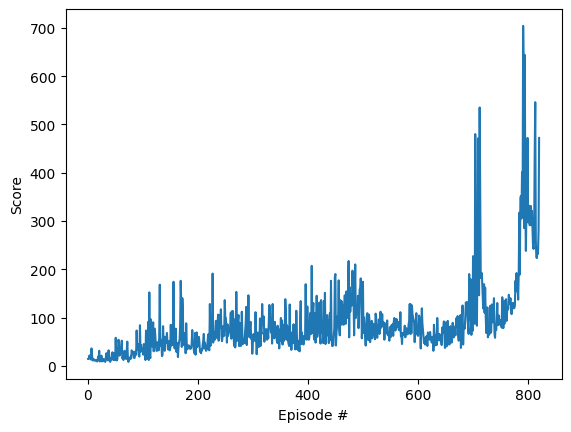

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

#### Issues

- High gradient varience: Since in frozenlake we get a reward only when it finishes, it might get trapped and don't converge at all. Similarly in cartpole it might neglect the episode of 5 steps over the one with 20 timesteps.
- Might get trained on coorelation of samples
- Exploration: So we add an entropy term = - $\sum \pi (a|s) \log \pi(a|s)$

Hence, this method isn't that popular these days and Actor - Critic methods are preffered

We can reduce these issues by:
- replacing $R(\tau)$ by $R^{future}(t)$
- introducing a baseline, ie replacing $R(\tau)$ by $(R_t - V(s))$. This V(s) can be learned by another neural network